In [1]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add

In [2]:

files_input_tr = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/input_*'))
files_target_tr = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/target_*'))
data_tr = CustomDataset(files_input_tr, files_target_tr)
dataset_tr = data_tr.get()
print("finish loading training dataset")

files_input_vl = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/validation_dataset/input_*'))
files_target_vl = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/validation_dataset/target_*'))
data_vl = CustomDataset(files_input_vl, files_target_vl)
dataset_vl = data_vl.get()
print("finish loading validation dataset")

finish loading training dataset
finish loading validation dataset


In [3]:
len(files_input_tr)+len(files_input_vl)

48799

In [4]:
BATCH_SIZE = 32
HIDDEN_CHANNELS=128
#loader_tr = DataLoader(dataset_tr, batch_size=BATCH_SIZE, drop_last=True)
loader_vl = DataLoader(dataset_vl, batch_size=BATCH_SIZE, drop_last=True)

In [5]:
from wmpgnn.model.gnn_model import EncodeProcessDecode

NUM_LAYERS = 4
HIDDEN_CHANNELS=128

MLP_OUTPUT_SIZE=16


In [6]:
myModel=EncodeProcessDecode(mlp_output_size=MLP_OUTPUT_SIZE, edge_op=4, num_blocks=8)

#myModel.cuda()



In [7]:
for vdata in loader_vl:
    break

In [8]:
vdata.nodes.shape

torch.Size([3018, 10])

In [9]:
vdata.nodes[0]

tensor([ 4.6491e-01,  2.6512e+00,  3.8462e+01,  1.6981e-01,  9.8180e-01,
         4.6676e+00,  6.1701e-03, -1.1261e-01,  2.5326e+01, -1.0000e+00])

In [ ]:
!ls 

In [10]:
BATCH_SIZE =32
#loader_tr = DataLoader(dataset_tr, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
loader_vl = DataLoader(dataset_vl, batch_size=BATCH_SIZE, drop_last=True)
count = 0
for vdata in loader_vl:
    count += 1
    if count == 15:
        break

vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
vdata.senders = vdata.senders - torch.min(vdata.senders)
vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)

vdata.cpu()
myModel.cpu()
#myModel.load_state_dict(torch.load('model_32_8block_epochs_pruning_latest.pth'))
#myModel.eval()
myModel.load_state_dict(torch.load('model_8block_34epochs_weighted_message_passing.pth'))
myModel.eval()

/tmp/ipykernel_59405/1513248420.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  myModel.load_state_dict(torch.load('model_8block_34epochs_weighted_message_passing.pth')

EncodeProcessDecode(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 16)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 16)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_nodes_aggregator): NodesToGlobalsAggregator()
      )
      (edge_linear): Linear(in_features=8, out_features=1, bias=True)
      (edge_mlp): MLP(-1, 16, 16, 1

In [39]:
weight_cut = 0.001
for i in range(2,8):
    if i == 3:
        weight_cut = 0.01
    if i == 4:
        weight_cut = 0.01
    if i == 5:
        weight_cut = 0.01
    if i == 6:
        weight_cut = 0.01
    myModel._blocks[i]._network.node_prune = True
    myModel._blocks[i]._network.prune_by_cut = True
    myModel._blocks[i]._network.node_weight_cut = weight_cut
    myModel._blocks[i]._network.device = 'cpu'
    
    myModel._blocks[i]._network.edge_prune = True
    myModel._blocks[i]._network.prune_by_cut = True
    myModel._blocks[i]._network.edge_weight_cut = weight_cut
    myModel._blocks[i]._network.device = 'cpu'
    

In [47]:
#import time

vdata.cpu()
myModel.cpu()
start = time.time()
gout = myModel(vdata,2)
end = time.time()

In [48]:
end-start

0.769026517868042

In [49]:
gout.graph_globals

tensor([[ 1.4792e-02,  6.7373e-02,  8.3022e-02,  2.9393e-02,  7.3247e-02,
          8.4628e-02, -2.2967e-02, -1.6842e-01, -3.8301e-02,  9.2257e-02,
         -7.3507e-02,  7.5729e-02, -1.1330e-01, -3.5233e-02, -4.9126e-03,
         -8.3840e-02],
        [ 1.0629e-02,  1.4429e-01,  8.9350e-02,  3.4204e-02,  3.9227e-02,
          1.3182e-01, -2.9462e-02, -2.1054e-01, -9.6628e-02,  9.2579e-02,
         -1.2979e-02,  8.7061e-02, -9.3785e-02,  1.0662e-02,  1.5746e-02,
         -7.3421e-02],
        [-3.2812e-02,  1.3019e-01,  4.8051e-02,  4.4628e-02,  2.5408e-02,
          1.3506e-01, -7.4777e-02, -2.0982e-01, -9.0033e-02,  1.1408e-01,
         -6.7280e-02,  7.8198e-02, -8.9906e-02, -1.5029e-02,  6.9757e-02,
         -5.9283e-02],
        [-4.7431e-02,  3.9902e-01,  3.0057e-02, -1.0361e-01, -3.2974e-02,
          2.2191e-01, -1.4582e-01, -4.2572e-01, -6.4289e-02,  2.9457e-01,
         -3.7220e-02,  1.0474e-01, -3.0783e-01,  5.7537e-02,  7.9725e-02,
         -2.0633e-01],
        [-2.5979e-01

In [13]:
import matplotlib.pyplot as plt

(array([ 0.62141579,  0.        ,  0.46606188,  0.4660618 ,  0.31070792,
         0.77676981,  0.31070781,  0.15535396,  0.31070792,  0.93212377,
         0.46606188,  0.46606188,  0.62141585,  1.55353961,  0.46606188,
         0.31070792,  0.31070792,  0.46606188,  0.93212377,  0.15535396,
         0.15535396,  0.46606119,  0.93212377,  0.31070792,  0.62141585,
         0.46606258,  0.46606119,  1.08747935,  1.39818357,  0.62141677,
         0.62141492,  0.46606258,  0.62141492,  0.62141492,  0.93212516,
         0.46606119,  0.62141677,  0.31070746,  0.77677096,  0.62141492,
         1.08747935,  0.93212238,  1.08747935,  1.08747611,  1.08747935,
         0.93212238,  0.77677096,  0.46606119,  0.93212516,  0.93212238,
         1.24282984,  0.93212794,  0.77676865,  1.24282984,  0.93212238,
         1.24282984,  1.70890122,  1.24282984,  0.46606119,  1.5535373 ,
         0.46606397,  0.93212238,  1.39818357,  0.77676865,  0.15535466,
         0.46606119,  0.62141492,  0.62141492,  0.9

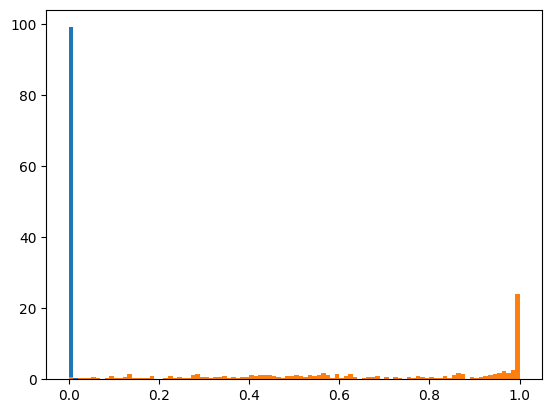

In [14]:
plt.hist(myModel._blocks[7]._network.edge_weights.detach().numpy()[gout.y[:,0] == 1],density=True,bins=100)
plt.hist(myModel._blocks[7]._network.edge_weights.detach().numpy()[gout.y[:,0] != 1],density=True, bins=100)

In [15]:
myModel._blocks[3]._network.node_weight_cut

0.001

In [58]:
myModel._blocks[7]._network.node_prune = True
myModel._blocks[7]._network.prune_by_cut = True
myModel._blocks[7]._network.node_weight_cut = 0.1
myModel._blocks[7]._network.device = 'cuda'

myModel._blocks[7]._network.edge_prune = True
myModel._blocks[7]._network.prune_by_cut = True
myModel._blocks[7]._network.edge_weight_cut = 0.1
myModel._blocks[7]._network.device = 'cuda'

myModel._blocks[7]._network.node_weight_cut = 0.1
myModel._blocks[7]._network.edge_weight_cut = 0.1

In [56]:
from wmpgnn.util.functions import weight_four_class, acc_four_class

last_batch_vl = len(loader_vl)


def eval_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    acc_one_epoch = []
    
    for j, vdata in enumerate(loader_vl): 

        vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
        vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
        vdata.senders = vdata.senders - torch.min(vdata.senders)
        vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
        vdata.to('cuda')
        yBCE_start = 1.*(vdata.y[:,0]==0).unsqueeze(1)
        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
        
        label0 = vdata.y.argmax(dim=1)
        answers = torch.ones_like(vdata.edges).cuda()
        try:
            outputs = myModel(vdata, num_processing_steps=STEP_SIZE)
        except:
            print("expception ")
            continue
        vdata = outputs
        label= vdata.y.argmax(dim=1)

        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
#         label= vdata.y
        
        if myModel._blocks[2]._network.node_prune == True:
            #indices= myModel._blocks[3]._network.edge_indices
            #indices= myModel._blocks[3]._network.edge_index
            indices = myModel._blocks[2]._network.edge_node_pruning_indices
            
            #print(label.shape)
            #loss = criterion(outputs.edges, label) 
            index = torch.ones(label0.shape[0], dtype=bool).cuda()
            index[indices] = False
            selected_labels = label0[index]
            answers[:,1:] = 0
            answers[indices] = outputs.edges
            num_nodes=vdata.nodes.shape[0]
            out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
            node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
            ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
            # include missing graph 
            #loss += criterion(answers[index], selected_labels)
            yBCE = 1.*(vdata.y[:,0]==0).unsqueeze(1)

        if myModel._blocks[2]._network.node_prune == True:
            acc_one_batch = acc_four_class(answers, label0)
        else:
            acc_one_batch = acc_four_class(outputs.edges, label)
        acc_one_epoch.append(acc_one_batch)
#         break
    
    acc_one_epoch=torch.stack(acc_one_epoch)

    return acc_one_epoch.nanmean(dim=0)

In [57]:
myModel.train(False)
myModel.cuda()
STEP_SIZE=2
vl_acc= eval_one_epoch(0)

expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 
expception 


KeyboardInterrupt: 

In [ ]:
vl_acc

In [20]:
vl_acc

NameError: name 'vl_acc' is not defined

In [21]:
vl_acc

NameError: name 'vl_acc' is not defined

In [59]:
def LCA_matrix_from_dict_removenull_reco(od):

    ytrue = torch.argmax(od.y,1)
    ypred = torch.argmax(od.edges,1)
    myModel._blocks[7]._network.edge_weights.cpu()
    edge_cut = (myModel._blocks[7]._network.edge_weights > 0.01).squeeze(1)
    new_senders = od.senders[ (ypred > 0) & edge_cut]
    new_receivers = od.receivers[ (ypred > 0) & edge_cut]
    edge_index = torch.vstack([new_senders,new_receivers])

    pd_matrix = pd.DataFrame(np.vstack(
        (edge_index[0], edge_index[1])).transpose(), columns=['senders', 'receivers'])
    pd_matrix["LCA_probs"] = list(od["edges"][ (ypred > 0) & edge_cut ].detach().numpy())
    pd_matrix["LCA_dec_true"] = list( np.argmax( od["y"][ (ypred > 0) & edge_cut ].detach().numpy() , axis = -1))
    pd_matrix["LCA_dec"] = list( np.argmax( od["edges"][ (ypred > 0) & edge_cut ].detach().numpy() , axis = -1))

    return pd_matrix

In [60]:
def LCA_matrix_from_dict_removenull_true(od):

    ytrue = torch.argmax(od.y,1)
    ypred = torch.argmax(od.edges,1)
    new_senders = od.senders[ ytrue > 0 ]
    new_receivers = od.receivers[ ytrue > 0 ]
    edge_index = torch.vstack([new_senders,new_receivers])

    pd_matrix = pd.DataFrame(np.vstack(
        (edge_index[0], edge_index[1])).transpose(), columns=['senders', 'receivers'])
    pd_matrix["LCA_probs"] = list(od["edges"][ ytrue > 0 ].detach().numpy())
    pd_matrix["LCA_dec"] = list( np.argmax( od["y"][ ytrue > 0 ].detach().numpy() , axis = -1))

    return pd_matrix

In [61]:
from numpy import intersect1d
from networkx.drawing.nx_agraph import graphviz_layout

In [62]:

def compute_LCA(anc1, anc2, max_depth):

    if (anc1 == []) or (anc2 == []):
        return 0

    common_ancestors = intersect1d(anc1, anc2).tolist()
    # IMPORTANT!!: the order of the ancestor indices reconstructed by this algorithm is the opposite of the one used in simulation, so the order must be reversed in this case.
    common_ancestors.reverse()

    if (common_ancestors == []):
        return 0

    lowest_common_ancestor = common_ancestors[-1]

    if (len(anc1) >= len(anc2)):
        max_length = anc1
    else:
        max_length = anc2
    lowest_common_ancestor_generation = max_length.index(
        lowest_common_ancestor)

    return max_depth - lowest_common_ancestor_generation

In [63]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [64]:
def reconstruct_decay(triang_LCA_matrix,particle_keys, ax=0, particle_ids=[], truth_level_simulation=0):
    '''
    Function used to reconstruct the decay chain
    '''
    #Nmax = np.max(np.unique( np.array( list(triang_LCA_matrix['senders']) + list(triang_LCA_matrix['receivers']))))
    num_clusters_per_order = {}
    for order_ in range(4):
        num_clusters_per_order[order_] = 0
    #particle_keys = list(range(0,Nmax+1))
    if particle_ids == []:
        labels = list(map(lambda x: 'k'+str(x), particle_keys))
    else:
        labels = list(map(lambda x, y: 'k'+str(x)+':' +
                      y, particle_keys, particle_ids))
    node_colors = []
    for l in labels:
        node_colors.append('#3e5948')

    max_full_chain_depth_in_event = -1

    # Create the global LCA matrix for the event, and remove null connections
    current_LCA_matrix = pd.DataFrame(triang_LCA_matrix, columns=[
                                      'senders', 'receivers', 'LCA_dec'])
    current_LCA_matrix = current_LCA_matrix[current_LCA_matrix['LCA_dec'] > 0]

    # Check against empty events
    if current_LCA_matrix.empty:
        print('No particles found.')
        return {}, num_clusters_per_order, max_full_chain_depth_in_event

    # Create a dictionary to store the true ID of the ancestors

    if truth_level_simulation:
        cluster_label_dict = pd.DataFrame(triang_LCA_matrix, columns=[
                                          'senders', 'receivers', 'LCA_id_label', 'TrueFullChainLCA'])
        cluster_label_dict.set_index(['senders', 'receivers'], inplace=True)
        max_full_chain_depth_in_event = max(
            cluster_label_dict['TrueFullChainLCA'].values)

    # Define an auxiliary matrix to later identify connected clusters
    #num_nodes = len(particle_keys)
    num_nodes = len(particle_keys)
    
    #num_nodes = len(np.unique( np.array( list(current_LCA_matrix['senders']) + list(current_LCA_matrix['receivers']))))
    #num_nodes  = np.max(np.unique( np.array( list(current_LCA_matrix['senders']) + list(current_LCA_matrix['receivers']))))
    #(num_nodes)
    clustering_adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Get the maximum of the LCA matrix
    max_depth = np.max(current_LCA_matrix['LCA_dec'])

    adj_links_list = []

    composite_counter = num_nodes - 1

    for order in range(max_depth):

        # print('order',order)

        LCA_matrix_subset = current_LCA_matrix[current_LCA_matrix['LCA_dec'] == 1]
        if LCA_matrix_subset.empty == False:

            # Reset the clustering adjacency matrix, and set it up to study the next LCA order
            clustering_adjacency_matrix = np.zeros(
                (composite_counter + 1, composite_counter + 1))
            #print('shape ', LCA_matrix_subset.shape[0])
            #print('shape ', LCA_matrix_subset.shape[0])
            for ie in range(LCA_matrix_subset.shape[0]):
                #print(LCA_matrix_subset)
                #print(LCA_matrix_subset.iloc[ie]['senders'] )
                clustering_adjacency_matrix[LCA_matrix_subset.iloc[ie]
                                            ['senders']][LCA_matrix_subset.iloc[ie]['receivers']] = 1
                clustering_adjacency_matrix[LCA_matrix_subset.iloc[ie]
                                            ['receivers']][LCA_matrix_subset.iloc[ie]['senders']] = 1
            nx_graph = nx.from_numpy_array(clustering_adjacency_matrix)
            connected_components = [
                list(x) for x in nx.connected_components(nx_graph) if len(x) > 1]

            # Inspect the separate clusters iteratively
            cl_counter = 0
            for indices_in_cluster in connected_components:

                # print('cluster counter',cl_counter)
                cl_counter += 1

                # Label the new cluster
                composite_counter += 1
                num_clusters_per_order[order] += 1
                if truth_level_simulation:
                    proxy_link = LCA_matrix_subset[(LCA_matrix_subset['senders'].isin(indices_in_cluster)) & (
                        LCA_matrix_subset['receivers'].isin(indices_in_cluster))].iloc[0]
                    labels.append('c'+str(composite_counter - num_nodes + 1) + ':' + cluster_label_dict.loc[(
                        proxy_link['senders'], proxy_link['receivers'])]['LCA_id_label'])
                else:
                    labels.append(
                        'reco_c'+str(composite_counter - num_nodes + 1))
                node_colors.append('#91b39d')

                # Pass the information to the reconstructed adjacency matrix
                for ind in indices_in_cluster:
                    new_df = pd.DataFrame({'senders': [ind],
                                           'receivers': [composite_counter],
                                           'link': [1]})
                    adj_links_list.append(new_df)

                # If there was any connection between the other nodes and any of the particles in the new cluster, connect those nodes to the new cluster as appropriate
                for sender in range(composite_counter):
                    if sender not in indices_in_cluster:
                        proxy_links = current_LCA_matrix[((current_LCA_matrix['senders'] == sender) & (current_LCA_matrix['receivers'].isin(
                            indices_in_cluster))) | ((current_LCA_matrix['senders'].isin(indices_in_cluster)) & (current_LCA_matrix['receivers'] == sender))]
                        if proxy_links.empty == False:
                            new_LCA_matrix_df = pd.DataFrame({
                                'senders': [sender],
                                'receivers': [composite_counter],
                                'LCA_dec': [max(proxy_links['LCA_dec'])]
                            })
                            LCA_matrix_list = []
                            LCA_matrix_list.append(current_LCA_matrix)
                            LCA_matrix_list.append(new_LCA_matrix_df)
                            current_LCA_matrix = pd.concat(
                                LCA_matrix_list, ignore_index=True)
                            if truth_level_simulation:
                                cluster_label_dict.loc[(sender, composite_counter), 'LCA_id_label'] = cluster_label_dict.loc[(
                                    proxy_links['senders'].iloc[0], proxy_links['receivers'].iloc[0]), 'LCA_id_label']

                # Remove connections with the nodes inside the new cluster
                current_LCA_matrix = current_LCA_matrix[(current_LCA_matrix['senders'].isin(
                    indices_in_cluster) == False) & (current_LCA_matrix['receivers'].isin(indices_in_cluster) == False)]

        current_LCA_matrix['LCA_dec'] = current_LCA_matrix['LCA_dec'] - 1
        current_LCA_matrix = current_LCA_matrix[current_LCA_matrix['LCA_dec'] > 0]

    if (adj_links_list):
        adj_links = pd.concat(adj_links_list, ignore_index=True)

    # Plot the tree
    if ax != 0:
        G = nx.DiGraph()

        adj_senders = adj_links['senders'].to_list()
        adj_receivers = adj_links['receivers'].to_list()
        filtered_node_colors = []
        for i in range(len(labels)):
            if i in adj_senders or i in adj_receivers:
                G.add_node(labels[i])
                filtered_node_colors.append(node_colors[i])

        for ie in range(adj_links.shape[0]):
            edge = adj_links.iloc[ie]
            G.add_edge(labels[edge['receivers']], labels[edge['senders']])

        pos = graphviz_layout(G, prog='dot')
        nx.draw(G, pos, with_labels=False,
                node_color=filtered_node_colors, node_size=1300, ax=ax)
        label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
        nx.draw_networkx_labels(G, pos, font_size=14,
                                bbox=label_options, ax=ax)

    # Compute information per separated decay chain

    final_adjacency_matrix = np.zeros(
        (composite_counter + 1, composite_counter + 1))
    for ie in range(adj_links.shape[0]):
        final_adjacency_matrix[adj_links.iloc[ie]
                               ['senders']][adj_links.iloc[ie]['receivers']] = 1
        final_adjacency_matrix[adj_links.iloc[ie]
                               ['receivers']][adj_links.iloc[ie]['senders']] = 1
    nx_graph = nx.from_numpy_array(final_adjacency_matrix)
    connected_components = [
        list(x) for x in nx.connected_components(nx_graph) if len(x) > 1]

    clustered_keys = []
    clustered_concatenated_LCA_values = []

    for nodes_in_cluster in connected_components:

        # Identify the keys of the final particles in the cluster, and list them in ascending order
        index_from_key_dict = {}
        for node in nodes_in_cluster:
            if node < num_nodes:
                index_from_key_dict[particle_keys[node]] = node
        ordered_keys_in_cluster = list(index_from_key_dict.keys())
        ordered_keys_in_cluster.sort()
        clustered_keys.append(ordered_keys_in_cluster)

        # Identify the list of ancestors for each final state particle
        ancestor_lists_in_cluster = []
        for k in ordered_keys_in_cluster:
            node_index = index_from_key_dict[k]
            ancestor_list = []
            current_link = adj_links[adj_links['senders'] == node_index]
            while current_link.empty == False:
                current_receiver = current_link.iloc[0]['receivers']
                ancestor_list.append(current_receiver)
                current_link = adj_links[adj_links['senders']
                                         == current_receiver]
            ancestor_list.reverse()
            ancestor_lists_in_cluster.append(ancestor_list)
        max_decay_length = max([len(x) for x in ancestor_lists_in_cluster])

        # Compute the LCA values and concatenate them following a given order
        concatenated_LCA_values_in_cluster = []
        for in1 in range(len(ordered_keys_in_cluster)):
            for in2 in range(len(ordered_keys_in_cluster)):
                if in1 < in2:
                    concatenated_LCA_values_in_cluster.append(compute_LCA(
                        ancestor_lists_in_cluster[in1], ancestor_lists_in_cluster[in2], max_decay_length))
        clustered_concatenated_LCA_values.append(
            concatenated_LCA_values_in_cluster)

    # Store the cluster information in a dictionary, with entries given by the smallest key value
    cluster_dict = {}
    for ic in range(len(connected_components)):
        cluster_dict[clustered_keys[ic][0]] = {
            'node_keys': clustered_keys[ic], 'LCA_values': clustered_concatenated_LCA_values[ic]}

    return cluster_dict, num_clusters_per_order, max_full_chain_depth_in_event

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
time_node_filtering = 0
time_edge_filtering = 0 
time_LCA_reconstruction = 0
#total_number_of_particles = len(particle_keys)
number_of_selected_particles_from_heavy_hadron_NPonly = 0 
number_of_selected_particles_from_heavy_hadron_NPandEPonly = 0 
compute_performance = 1
signal_df = pd.DataFrame(columns=['EventNumber', 'NumParticlesInEvent', 'NumSignalParticles', 'PerfectSignalReconstruction', 'AllParticles','PerfectReco',
                                 'NoneIso', 'PartReco', 'NotFound'])
signal_df = signal_df.astype({'EventNumber': np.int32, 'NumParticlesInEvent': np.int32, 'NumSignalParticles': np.int32, 'PerfectSignalReconstruction': np.int32,
                              'AllParticles': np.int32,'PerfectReco': np.int32,
                                 'NoneIso': np.int32, 'PartReco': np.int32, 'NotFound': np.int32})



event_df = pd.DataFrame(columns=['EventNumber', 'NumParticlesInEvent', 'NumParticlesFromHeavyHadronInEvent', 'NumBackgroundParticlesInEvent', 'NumSelectedParticlesInEvent', 'NumSelectedParticlesFromHeavyHadronInEvent',
                                     'NumSelectedParticlesFromHeavyHadronInEventNPOnly', 'NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly', 'NumSelectedBackgroundParticlesInEvent', 'NumTruthClustersGen1', 'NumTruthClustersGen2',
                                     'NumTruthClustersGen3', 'NumTruthClustersGen4', 'NumRecoClustersGen1', 'NumRecoClustersGen2', 'NumRecoClustersGen3', 'NumRecoClustersGen4', 'MaxTruthFullChainDepthInEvent',
                                     'EfficiencyParticlesFromHeavyHadronInEvent', 'EfficiencyBackgroundParticlesInEvent', 'BackgroundRejectionPowerInEvent', 'PerfectEventReconstruction', 'TimeNodeFiltering', 'TimeEdgeFiltering',
                                     'TimeLCAReconstruction', 'TimeSequence', 'NumTrueSignalsInEvent', 'NumRecoSignalsInEvent','TimeModel','TimeReco','TimeTruth'])

In [67]:
signal_df

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction,AllParticles,PerfectReco,NoneIso,PartReco,NotFound


In [31]:
event_df

,EventNumber,NumParticlesInEvent,NumParticlesFromHeavyHadronInEvent,NumBackgroundParticlesInEvent,NumSelectedParticlesInEvent,NumSelectedParticlesFromHeavyHadronInEvent,NumSelectedParticlesFromHeavyHadronInEventNPOnly,NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly,NumSelectedBackgroundParticlesInEvent,NumTruthClustersGen1,...,PerfectEventReconstruction,TimeNodeFiltering,TimeEdgeFiltering,TimeLCAReconstruction,TimeSequence,NumTrueSignalsInEvent,NumRecoSignalsInEvent,TimeModel,TimeReco,TimeTruth


In [32]:
truth_cluster_dict

NameError: name 'truth_cluster_dict' is not defined

In [38]:
reco_cluster_dict2= {10: {'node_keys': [10, 11], 'LCA_values': [1, 1, 1]},
 12: {'node_keys': [12, 13, 21], 'LCA_values': [1]}}

In [39]:
reco_cluster_dict

NameError: name 'reco_cluster_dict' is not defined

In [231]:
# perfect_reco = 0
# all_particles = 0

# for true_cluster in truth_cluster_dict.values():
#     for cluster in reco_cluster_dict2.values():
#         val = np.sum( np.isin(cluster['node_keys'],true_cluster['node_keys']))/len(true_cluster['node_keys'])
#         print(val)
#         if cluster['node_keys'] == true_cluster['node_keys']:
#             all_particles = 1
#             if cluster['LCA_values'] == true_cluster['LCA_values']:
#                 perfect_reco = 1
#         elif val >= 0.1 and val < 1:
#             part_reco = 1
#             print("part reco")
#         elif val >= 0.1 and len(cluster['node_keys']) > len(true_cluster['node_keys']):
#             none_iso = 1
#             print("none iso")

0.6666666666666666
part reco
0.0
0.0
1.0
none iso


In [192]:
truth_cluster_dict

{39: {'node_keys': [39, 40, 41, 44, 45, 46, 47],
  'LCA_values': [1,
   1,
   2,
   2,
   2,
   2,
   1,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   1,
   1,
   1,
   1,
   1,
   1]}}

In [196]:
truth_num_clusters_per_order

{0: 2, 1: 1, 2: 0, 3: 0}

In [195]:
truth_cluster_dict

{39: {'node_keys': [39, 40, 41, 44, 45, 46, 47],
  'LCA_values': [1,
   1,
   2,
   2,
   2,
   2,
   1,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   1,
   1,
   1,
   1,
   1,
   1]}}

In [191]:
if reco_cluster_dict != {}:
    print("here")

here


In [197]:
for tc_firstkey in truth_cluster_dict.keys():
    print(tc_firstkey)

39


In [68]:
BATCH_SIZE = 1
#loader_tr = DataLoader(dataset_tr, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
loader_vl = DataLoader(dataset_vl, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
j = 0
event = 0
event=0
count=0
count2=0
count3= 0 
time_model = 0
time_reco = 0
for vdata in loader_vl:
    #if event == 1000:
    #    break
    if event%100 == 0:
        print(event)
    Bparts = float(torch.sum(torch.argmax(vdata.y,-1)>0))
    if Bparts < 1:
        continue
    count3+=1
    vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
    vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
    vdata.senders = vdata.senders - torch.min(vdata.senders)
    vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)

    particle_keys = torch.unique( vdata.receivers)
    particle_keys = list(particle_keys.numpy())
    vdata.cuda()
    vdata_copy = vdata.clone()
    myModel.cuda()
    myModel._blocks[7]._network.node_weight_cut = 0.1
    myModel._blocks[7]._network.edge_weight_cut = 0.1
    try:
        start_time = time.time()
        gout = myModel(vdata, 2)
        end_time = time.time()
        time_model = end_time-start_time
    except:
        print("Pruning looser")
        myModel._blocks[7]._network.node_weight_cut = 0.03
        myModel._blocks[7]._network.edge_weight_cut = 0.03
        try:
            start_time = time.time()
            gout = myModel(vdata_copy, 2)
            end_time = time.time()
            time_model = end_time-start_time
        except:
            print("Exception occurred")
            continue
    myModel.cpu()
    gout.cpu()
    vdata.cpu()
    Bparts_after = float(torch.sum(torch.argmax(vdata.y,-1)>0))
    if Bparts_after < Bparts:
        print("Bparts lost, before had ", Bparts, " and now ", Bparts_after )
    #particle_keys = torch.unique( gout.receivers)
    #particle_keys = list(particle_keys.numpy())
    myModel._blocks[7]._network.edge_weights = myModel._blocks[7]._network.edge_weights.cpu()
    start_time = time.time()
    reco_LCA = LCA_matrix_from_dict_removenull_reco(gout)
    reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
        reco_LCA, particle_keys)
    end_time = time.time()
    time_reco = end_time-start_time
    start_time = time.time()
    true_LCA = LCA_matrix_from_dict_removenull_true(vdata)

    truth_cluster_dict, truth_num_clusters_per_order, max_full_chain_depth_in_event = reconstruct_decay(
        true_LCA, particle_keys)
    end_time = time.time()
    time_truth = end_time-start_time
    compute_performance = 1
    if compute_performance == 1:
        time_node_filtering = 0
        time_edge_filtering = 0 
        time_LCA_reconstruction = 0
        total_number_of_particles = len(particle_keys)
        number_of_selected_particles_from_heavy_hadron_NPonly = 0 
        number_of_selected_particles_from_heavy_hadron_NPandEPonly = 0 
        #f truth_cluster_dict == {}:
        #    count += 1
        if truth_cluster_dict != {}:
            count+=1
    
            # Compute performance metrics
            particles_from_heavy_hadron = flatten([truth_cluster_dict[tc_firstkey]['node_keys'] for tc_firstkey in truth_cluster_dict.keys()])
            number_of_particles_from_heavy_hadron = len(particles_from_heavy_hadron)
            number_of_selected_particles_from_heavy_hadron_NPonly = number_of_particles_from_heavy_hadron
            number_of_selected_particles_from_heavy_hadron_NPandEPonly = number_of_particles_from_heavy_hadron
            number_of_background_particles = total_number_of_particles - number_of_particles_from_heavy_hadron
            if reco_cluster_dict != {}:
                selected_particles = flatten([reco_cluster_dict[tc_firstkey]['node_keys'] for tc_firstkey in reco_cluster_dict.keys()])
                number_of_selected_particles = len(selected_particles)
                number_of_selected_particles_from_heavy_hadron = len(list(set(selected_particles).intersection(particles_from_heavy_hadron)))
                number_of_selected_background_particles = number_of_selected_particles - number_of_selected_particles_from_heavy_hadron
            else:
                number_of_selected_particles = 0
                number_of_selected_particles_from_heavy_hadron = 0
                number_of_selected_background_particles = 0
    
            perfect_event_reconstruction = 1
            if number_of_selected_background_particles > 0:
                perfect_event_reconstruction = 0
   

            for tc_firstkey in truth_cluster_dict.keys():
                number_of_signal_particles = len(truth_cluster_dict[tc_firstkey]['node_keys'])
                perfect_signal_reconstruction = 1
                if reco_cluster_dict == {}:
                    perfect_signal_reconstruction = 0
                else:
                    if tc_firstkey not in reco_cluster_dict.keys():
                        perfect_signal_reconstruction = 0
                    else:
                        if reco_cluster_dict[tc_firstkey]['node_keys'] != truth_cluster_dict[tc_firstkey]['node_keys'] or reco_cluster_dict[tc_firstkey]['LCA_values'] != truth_cluster_dict[tc_firstkey]['LCA_values']:
                            perfect_signal_reconstruction = 0
                perfect_event_reconstruction *= perfect_signal_reconstruction

                true_cluster = truth_cluster_dict[tc_firstkey]
                perfect_reco = 0
                all_particles = 0
                none_iso = 0
                part_reco = 0
                none_associated = 0
                for cluster in reco_cluster_dict.values():
                    true_in_reco = np.sum( np.isin(true_cluster['node_keys'],cluster['node_keys']))/len(true_cluster['node_keys'])
                    #reco_in_true = np.sum( np.isin(cluster['node_keys'],true_cluster['node_keys']))/len(true_cluster['node_keys'])
                    #print(val)
                    if cluster['node_keys'] == true_cluster['node_keys']:
                        all_particles = 1
                        if cluster['LCA_values'] == true_cluster['LCA_values']:
                            perfect_reco = 1
                        break
                    elif true_in_reco == 1 and len(cluster['node_keys']) > len(true_cluster['node_keys']):
                        none_iso = 1
                    elif true_in_reco >= 0.2 and true_in_reco < 1:
                        part_reco = 1
                    #elif val >= 0.2 and len(cluster['node_keys']) > len(true_cluster['node_keys']):
                    #    none_iso = 1
                if all_particles == 1:
                    none_iso = 0
                    part_reco = 0

                if all_particles == 0 and none_iso == 0 and part_reco == 0:
                    none_associated = 1
                signal_df = signal_df._append({'EventNumber' : event,
                                              'NumParticlesInEvent': total_number_of_particles,
                                              'NumSignalParticles': number_of_signal_particles,
                                              'PerfectSignalReconstruction': perfect_signal_reconstruction,
                                              'AllParticles': all_particles,
                                              'PerfectReco': perfect_reco,
                                              'NoneIso' : none_iso,
                                              'PartReco' : part_reco,
                                              'NotFound' : none_associated},
                                           ignore_index=True)    
                count2+=1
            #if perfect_signal_reconstruction:
            #    break
            event+=1
            event_df = event_df._append({'EventNumber': event,
                                            'NumParticlesInEvent': total_number_of_particles,
                                            'NumParticlesFromHeavyHadronInEvent': number_of_particles_from_heavy_hadron,
                                            'NumBackgroundParticlesInEvent': number_of_background_particles,
                                            'NumSelectedParticlesInEvent': number_of_selected_particles,
                                            'NumSelectedParticlesFromHeavyHadronInEvent': number_of_selected_particles_from_heavy_hadron,
                                            'NumSelectedParticlesFromHeavyHadronInEventNPOnly': number_of_selected_particles_from_heavy_hadron_NPonly,
                                            'NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly': number_of_selected_particles_from_heavy_hadron_NPandEPonly,
                                            'NumSelectedBackgroundParticlesInEvent': number_of_selected_background_particles,
                                            'NumTruthClustersGen1': truth_num_clusters_per_order[0],
                                            'NumTruthClustersGen2': truth_num_clusters_per_order[1],
                                            'NumTruthClustersGen3': truth_num_clusters_per_order[2],
                                            'NumTruthClustersGen4': truth_num_clusters_per_order[3],
                                            'NumRecoClustersGen1': reco_num_clusters_per_order[0],
                                            'NumRecoClustersGen2': reco_num_clusters_per_order[1],
                                            'NumRecoClustersGen3': reco_num_clusters_per_order[2],
                                            'NumRecoClustersGen4': reco_num_clusters_per_order[3],
                                            'MaxTruthFullChainDepthInEvent': max_full_chain_depth_in_event,
                                            'EfficiencyParticlesFromHeavyHadronInEvent': float(number_of_selected_particles_from_heavy_hadron) / number_of_particles_from_heavy_hadron,
                                            'EfficiencyBackgroundParticlesInEvent': float(number_of_selected_background_particles) / number_of_background_particles,
                                            'BackgroundRejectionPowerInEvent': 1. - float(number_of_selected_background_particles) / number_of_background_particles,
                                            'PerfectEventReconstruction': perfect_event_reconstruction,
                                            'TimeNodeFiltering': time_node_filtering,
                                            'TimeEdgeFiltering': time_edge_filtering,
                                            'TimeLCAReconstruction': time_LCA_reconstruction,
                                            'TimeSequence': time_node_filtering + time_edge_filtering + time_LCA_reconstruction,
                                            'NumTrueSignalsInEvent': len(truth_cluster_dict.keys()),
                                            'NumRecoSignalsInEvent': len(reco_cluster_dict.keys()),
                                            'TimeModel' : time_model,
                                            'TimeReco': time_reco,
                                            'TimeTruth': time_truth},
                                           ignore_index=True) 

0


/tmp/ipykernel_10104/1896285824.py:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_df = event_df._append({'EventNumber': event,


Pruning looser
Pruning looser
100
Pruning looser
Pruning looser
Exception occurred
200
Pruning looser
Exception occurred
Pruning looser
Exception occurred
300
300
300
Pruning looser
Pruning looser
400
Pruning looser
Pruning looser
500
600
Pruning looser
700
Pruning looser
Pruning looser
800
800
Pruning looser
900
1000
Pruning looser
Pruning looser
1100
1200
1300
1400
1400
1500
Pruning looser
1600
1700
1800
1900
Pruning looser
2000
2100
2200
Pruning looser
2300
2400
2500
Pruning looser
Exception occurred
2600
Pruning looser
Exception occurred
2700
2800
Pruning looser
2900
3000
3100
3200
3300
3300
Pruning looser
Pruning looser
Exception occurred
Pruning looser
3400
3500
Pruning looser
Exception occurred
3600
3700
3700
Pruning looser
Pruning looser
3800
3900
3900
Pruning looser
4000
Pruning looser
4100
4200
4300
Pruning looser
4400
4500
4600
Pruning looser
4700
4800
4900
4900
4900
5000
Pruning looser
Exception occurred
5100
5200
Pruning looser
5300
Pruning looser
Pruning looser
Exception 

In [43]:
myModel._blocks[7]._network.edge_prune 

True

In [69]:
signal_df

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction,AllParticles,PerfectReco,NoneIso,PartReco,NotFound
0,0,40,2,0,0,0,1,0,0
1,0,40,5,0,0,0,1,0,0
2,1,95,4,0,0,0,1,0,0
3,1,95,3,0,0,0,0,0,1
4,2,105,6,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
11647,8239,105,3,0,0,0,0,1,0
11648,8240,106,5,0,1,0,0,0,0
11649,8241,61,5,0,1,0,0,0,0
11650,8242,114,2,0,0,0,1,0,0


In [70]:
len(signal_df.query('PerfectSignalReconstruction == 1'))/len(signal_df)

0.1777377274287676

In [71]:
len(signal_df.query('PerfectReco == 1'))/len(signal_df)

0.1777377274287676

In [75]:
len(signal_df.query('AllParticles == 1'))/len(signal_df)

0.35805012015104704

In [76]:
(len(signal_df.query('AllParticles == 1')) - len(signal_df.query('PerfectSignalReconstruction == 1')))/len(signal_df)

0.18031239272227945

In [74]:
len(signal_df.query('PartReco == 1'))/len(signal_df)

0.0706316512186749

In [39]:
31+7.7+59.5

98.2

In [40]:
31+7.8+58

96.8

In [77]:
len(signal_df.query('NoneIso == 1'))/len(signal_df)

0.5511500171644352

In [78]:
len(signal_df.query('NotFound == 1'))/len(signal_df)

0.020168211465842772

In [43]:
np.mean(event_df.TimeModel)

0.032757644903221625

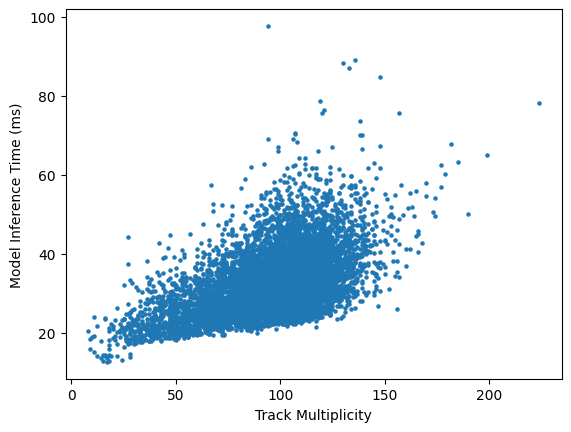

In [44]:
plt.scatter(event_df.NumParticlesInEvent,event_df.TimeModel*1000,s=5)
plt.ylabel('Model Inference Time (ms)')
plt.xlabel('Track Multiplicity')
plt.savefig("model_time_pruning.png",dpi=300)

In [45]:
np.mean(event_df.TimeModel*1000)

32.757644903221625

In [46]:
np.mean(event_df.TimeReco*1000)

68.98648539576357

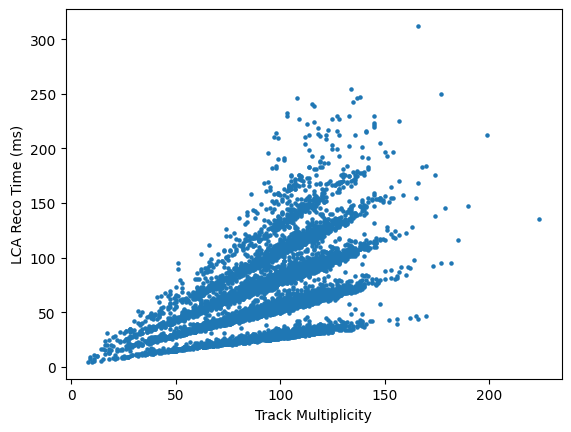

In [47]:
plt.scatter(event_df.NumParticlesInEvent,event_df.TimeReco*1000,s=5)
plt.ylabel('LCA Reco Time (ms)')
plt.xlabel('Track Multiplicity')
plt.savefig("reco_time_pruning.png",dpi=300)

Text(0.5, 0, 'Track Multiplicity')

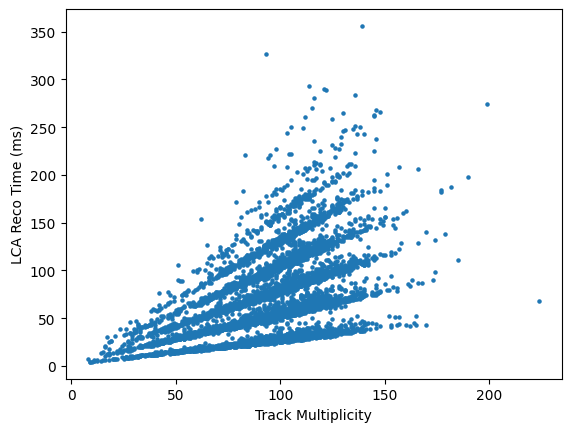

In [100]:
plt.scatter(event_df.NumParticlesInEvent,event_df.TimeTruth*1000,s=5)
plt.ylabel('LCA Reco Time (ms)')
plt.xlabel('Track Multiplicity')

In [47]:
event_df

,EventNumber,NumParticlesInEvent,NumParticlesFromHeavyHadronInEvent,NumBackgroundParticlesInEvent,NumSelectedParticlesInEvent,NumSelectedParticlesFromHeavyHadronInEvent,NumSelectedParticlesFromHeavyHadronInEventNPOnly,NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly,NumSelectedBackgroundParticlesInEvent,NumTruthClustersGen1,...,BackgroundRejectionPowerInEvent,PerfectEventReconstruction,TimeNodeFiltering,TimeEdgeFiltering,TimeLCAReconstruction,TimeSequence,NumTrueSignalsInEvent,NumRecoSignalsInEvent,TimeModel,TimeReco
0,1.0,111.0,4.0,107.0,6.0,4.0,4.0,4.0,2.0,1.0,...,0.981308,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.048979,0.158499
1,2.0,32.0,13.0,19.0,13.0,13.0,13.0,13.0,0.0,2.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.024344,0.095977
2,3.0,111.0,3.0,108.0,3.0,3.0,3.0,3.0,0.0,0.0,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.052489,0.106443
3,4.0,141.0,10.0,131.0,11.0,10.0,10.0,10.0,1.0,2.0,...,0.992366,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.055733,0.381606
4,5.0,54.0,6.0,48.0,6.0,6.0,6.0,6.0,0.0,1.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.033638,0.099424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,8238.0,111.0,10.0,101.0,10.0,10.0,10.0,10.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.030449,0.155424
8238,8239.0,93.0,3.0,90.0,3.0,3.0,3.0,3.0,0.0,1.0,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.031560,0.057988
8239,8240.0,62.0,6.0,56.0,7.0,6.0,6.0,6.0,1.0,2.0,...,0.982143,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.023874,0.116435
8240,8241.0,109.0,12.0,97.0,13.0,12.0,12.0,12.0,1.0,1.0,...,0.989691,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.030805,0.254211


In [44]:
signal_df.query('NotFound == 1')

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction,AllParticles,PerfectReco,NoneIso,PartReco,NotFound
57,39,115,2,0,0,0,0,0,1
60,40,122,2,0,0,0,0,0,1
186,126,148,10,0,0,0,0,0,1
207,142,103,2,0,0,0,0,0,1
240,164,66,4,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
11491,8128,63,2,0,0,0,0,0,1
11509,8141,116,2,0,0,0,0,0,1
11595,8204,80,2,0,0,0,0,0,1
11613,8216,70,2,0,0,0,0,0,1


In [241]:
signal_df

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction,AllParticles,PerfectReco,NoneIso,PartReco,NotFound
0,0,105,7,0,0,0,1,1,0
1,1,137,7,0,1,0,0,1,1
2,2,133,3,0,0,0,1,1,0
3,3,99,4,0,0,0,1,1,0
4,3,99,9,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
4863,3413,76,6,0,0,0,1,1,0
4864,3414,111,4,0,0,0,1,1,0
4865,3414,111,2,0,0,0,1,1,0
4866,3415,103,5,0,0,0,1,1,0


In [214]:
event_df

,EventNumber,NumParticlesInEvent,NumParticlesFromHeavyHadronInEvent,NumBackgroundParticlesInEvent,NumSelectedParticlesInEvent,NumSelectedParticlesFromHeavyHadronInEvent,NumSelectedParticlesFromHeavyHadronInEventNPOnly,NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly,NumSelectedBackgroundParticlesInEvent,NumTruthClustersGen1,...,BackgroundRejectionPowerInEvent,PerfectEventReconstruction,TimeNodeFiltering,TimeEdgeFiltering,TimeLCAReconstruction,TimeSequence,NumTrueSignalsInEvent,NumRecoSignalsInEvent,TimeModel,TimeReco
0,1.0,110.0,4.0,106.0,12.0,4.0,4.0,4.0,8.0,1.0,...,0.924528,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.023547,0.224932
1,2.0,89.0,6.0,83.0,9.0,6.0,6.0,6.0,3.0,2.0,...,0.963855,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.041271,0.144832
2,3.0,62.0,4.0,58.0,5.0,4.0,4.0,4.0,1.0,0.0,...,0.982759,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.032155,0.038557
3,4.0,81.0,5.0,76.0,8.0,5.0,5.0,5.0,3.0,1.0,...,0.960526,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.030178,0.128706
4,5.0,65.0,5.0,60.0,12.0,5.0,5.0,5.0,7.0,1.0,...,0.883333,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.021332,0.126664
5,6.0,91.0,6.0,85.0,10.0,6.0,6.0,6.0,4.0,2.0,...,0.952941,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.027571,0.146444
6,7.0,46.0,3.0,43.0,3.0,3.0,3.0,3.0,0.0,1.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.021993,0.042035
7,8.0,93.0,7.0,86.0,16.0,7.0,7.0,7.0,9.0,1.0,...,0.895349,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.026458,0.173471
8,9.0,86.0,2.0,84.0,17.0,2.0,2.0,2.0,15.0,0.0,...,0.821429,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.030183,0.072260
9,10.0,122.0,10.0,112.0,13.0,10.0,10.0,10.0,3.0,1.0,...,0.973214,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.018430,0.178627


AttributeError: 'GraphNetwork' object has no attribute 'cut'

In [26]:
signal_df

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction
0,0,60,3,0
1,0,60,3,0
2,1,128,6,0
3,2,92,3,0
4,2,92,6,0
...,...,...,...,...
11637,8229,106,4,0
11638,8230,121,3,0
11639,8231,119,8,0
11640,8231,119,3,0


In [40]:
#event_df

In [41]:
#reco_LCA

In [42]:
#true_LCA

In [43]:
#signal_df

In [51]:
vdata

DataBatch(y=[5504, 4], nodes=[125, 8], edges=[5504, 8], senders=[5504], receivers=[5504], graph_globals=[1, 8], edgepos=[5504], num_edges=[1], num_nodes=125, batch=[125], ptr=[2])

In [56]:
myModel

EncodeProcessDecode(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 8)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 8)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 8)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_nodes_aggregator): NodesToGlobalsAggregator()
      )
      (edge_linear): Linear(in_features=8, out_features=1, bias=True)
      (edge_mlp): MLP(-1, 16, 16, 16, 1)


In [50]:
gout.edges

tensor([[-5.8536e+00,  2.7277e+00,  3.7795e+00,  4.1526e-02],
        [-5.4295e+00,  2.0275e+00,  4.0623e+00, -7.3917e-01],
        [-5.5303e+00,  1.9887e+00,  4.1316e+00, -4.5727e-01],
        [-5.9066e+00,  3.0109e+00,  3.6850e+00, -2.4289e-01],
        [-2.6575e+00, -4.1691e+00,  7.7254e+00,  2.8191e+00],
        [-2.7890e+00, -3.7674e+00,  7.4019e+00,  2.7143e+00],
        [-2.9336e+00, -3.5360e+00,  7.3790e+00,  2.2925e+00],
        [-5.6402e+00,  2.4622e+00,  3.7255e+00,  2.2017e-01],
        [-5.6761e+00,  2.5108e+00,  3.7263e+00,  2.1824e-01],
        [-5.8952e+00,  2.6041e+00,  3.9355e+00,  6.4340e-03],
        [-2.8990e+00, -3.8153e+00,  7.5661e+00,  2.8298e+00],
        [-2.9333e+00, -3.7147e+00,  7.4865e+00,  2.8254e+00],
        [-3.0748e+00, -3.2908e+00,  7.2406e+00,  2.2795e+00],
        [-5.7093e+00,  2.4092e+00,  3.9940e+00, -5.2751e-01],
        [-5.6848e+00,  2.4340e+00,  3.8449e+00, -8.4130e-03],
        [-2.6532e+00, -4.2959e+00,  7.8616e+00,  2.9197e+00],
        

In [55]:
torch.argmax(gout.edges, -1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 1, 1, 1])

In [182]:
signal_df

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction
0,0,115,5,0
1,1,112,3,0
2,2,47,4,0
3,3,121,4,0
4,4,106,7,0
...,...,...,...,...
11664,5,90,7,0
11665,6,105,6,0
11666,6,105,3,0
11667,7,108,5,0


<Figure size 640x480 with 0 Axes>

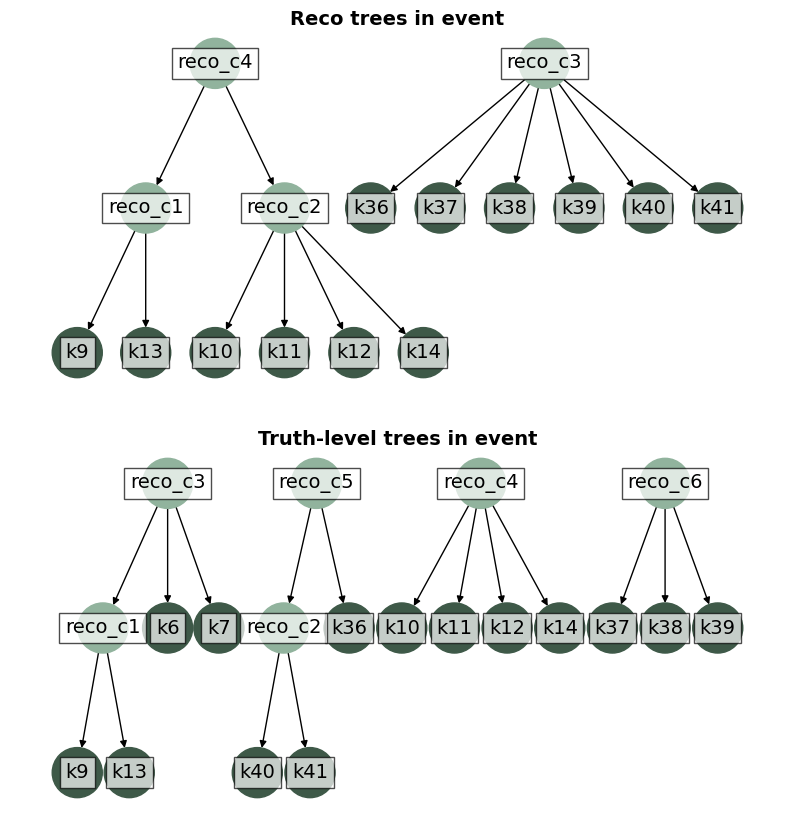

In [70]:
import matplotlib.pyplot as plt

save_plot = 1

if save_plot == 1:
    plt.clf()
    fix, axs = plt.subplots(2, figsize=(10, 10))
    axs[0].set_title('Reco trees in event',
                     fontweight='bold', fontsize=14)
    reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
        reco_LCA, particle_keys,  axs[0])

    #plt.savefig("reco_attempt1.png")
    axs[1].set_title('Truth-level trees in event',
                     fontweight='bold', fontsize=14)
    truth_cluster_dict, truth_num_clusters_per_order, max_full_chain_depth_in_event = reconstruct_decay(
        true_LCA, particle_keys,  axs[1])
    plt.savefig("reco_attempt_example_test.png")

In [85]:
reco_LCA

,senders,receivers,LCA_probs,LCA_dec_true,LCA_dec
0,26,21,"[-4.9038258, 1.9631735, 3.348852, 0.06233783]",2,2
1,27,21,"[-4.9226756, 2.4646733, 3.0773466, -0.43269432]",2,2
2,28,21,"[-4.775348, 2.5148737, 2.9207428, -0.6175655]",2,2
3,25,24,"[-4.692808, 2.641245, 2.341446, 0.45813936]",2,1
4,29,24,"[-4.97298, 3.05139, 2.3487253, 0.16667233]",2,1
5,30,24,"[-4.6727786, 2.7076223, 2.238047, 0.447321]",2,1
6,29,25,"[-4.7968683, 2.7051663, 2.5782633, 0.26832777]",2,1
7,30,25,"[-4.672346, 2.5618575, 2.5808237, 0.33943468]",2,2
8,27,26,"[-5.1082163, 3.6156287, 2.2109635, -0.6724746]",1,1
9,28,26,"[-5.5250416, 4.0938582, 2.2207656, -0.75975084]",1,1


In [81]:
vdata.y

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])

In [79]:
true_LCA

,senders,receivers,LCA_probs,LCA_dec
0,31,30,"[1.374594, -0.4782313, -0.29296, -0.52507114, ...",2
1,30,31,"[1.3518643, -0.57753783, -0.23267898, -0.31037...",2


In [24]:
vdata

DataBatch(y=[1968, 4], nodes=[45, 4], edges=[1968, 4], senders=[1968], receivers=[1968], graph_globals=[1], edgepos=[1968], num_edges=[1], num_nodes=45, batch=[45], ptr=[2])

In [25]:
gout

DataBatch(y=[22, 4], nodes=[139, 8], edges=[22, 4], senders=[22], receivers=[22], graph_globals=[1, 8], edgepos=[22], num_edges=[1], num_nodes=139, batch=[139], ptr=[2])

In [26]:
signal_df

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction
0,1,116,5,0
1,2,127,3,1
2,4,115,4,0
3,5,86,5,0
4,5,86,3,0
...,...,...,...,...
2443,1996,76,7,0
2444,1996,76,2,1
2445,1998,82,4,0
2446,1998,82,8,0


In [27]:
event_df

,EventNumber,NumParticlesInEvent,NumParticlesFromHeavyHadronInEvent,NumBackgroundParticlesInEvent,NumSelectedParticlesInEvent,NumSelectedParticlesFromHeavyHadronInEvent,NumSelectedParticlesFromHeavyHadronInEventNPOnly,NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly,NumSelectedBackgroundParticlesInEvent,NumTruthClustersGen1,...,EfficiencyParticlesFromHeavyHadronInEvent,EfficiencyBackgroundParticlesInEvent,BackgroundRejectionPowerInEvent,PerfectEventReconstruction,TimeNodeFiltering,TimeEdgeFiltering,TimeLCAReconstruction,TimeSequence,NumTrueSignalsInEvent,NumRecoSignalsInEvent
0,1.0,116.0,5.0,111.0,6.0,5.0,5.0,5.0,1.0,1.0,...,1.000000,0.009009,0.990991,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2.0,127.0,3.0,124.0,6.0,3.0,3.0,3.0,3.0,0.0,...,1.000000,0.024194,0.975806,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,4.0,115.0,4.0,111.0,11.0,4.0,4.0,4.0,7.0,1.0,...,1.000000,0.063063,0.936937,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,5.0,86.0,8.0,78.0,8.0,8.0,8.0,8.0,0.0,0.0,...,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0
4,6.0,66.0,4.0,62.0,4.0,4.0,4.0,4.0,0.0,1.0,...,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,1994.0,109.0,3.0,106.0,5.0,3.0,3.0,3.0,2.0,1.0,...,1.000000,0.018868,0.981132,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1736,1995.0,34.0,5.0,29.0,5.0,5.0,5.0,5.0,0.0,2.0,...,1.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1737,1996.0,76.0,9.0,67.0,9.0,9.0,9.0,9.0,0.0,2.0,...,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1738,1998.0,82.0,12.0,70.0,12.0,12.0,12.0,12.0,0.0,2.0,...,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0


In [40]:
signal_df

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction
0,1,88,3,0
1,2,78,4,0
2,3,118,5,0
3,3,118,3,1
4,5,77,5,0
...,...,...,...,...
1232,994,126,7,0
1233,996,100,6,0
1234,997,69,4,0
1235,998,64,3,0


In [41]:
signal_df.query('PerfectSignalReconstruction == 1')

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction
3,3,118,3,1
5,7,92,3,1
9,9,128,3,1
11,11,63,2,1
19,18,106,5,1
...,...,...,...,...
1190,959,104,3,1
1199,966,97,4,1
1202,969,99,2,1
1222,987,93,3,1


In [163]:
signal_df.to_csv("signal_df_tight_new.csv")

In [164]:
event_df.to_csv("event_df_tight_new.csv")

In [43]:
len(signal_df)  


1237

In [164]:
len(signal_df.query('PerfectSignalReconstruction == 1')) / len(signal_df)

0.07359752959341224

In [31]:
len(signal_df.query('PerfectSignalReconstruction == 1')) / (count3*2)

0.07206007024342982

In [30]:
len(signal_df)

11604

In [35]:
count3

1001

In [36]:
count2

1409

In [41]:
event_df['NumParticlesFromHeavyHadronInEvent']

0      7.0
1      3.0
2      3.0
3      8.0
4      2.0
      ... 
995    4.0
996    6.0
997    8.0
998    3.0
999    5.0
Name: NumParticlesFromHeavyHadronInEvent, Length: 1000, dtype: float64

In [47]:
event_df["NumSelectedParticlesFromHeavyHadronInEvent"]

0      7.0
1      3.0
2      3.0
3      8.0
4      2.0
      ... 
995    4.0
996    6.0
997    8.0
998    3.0
999    5.0
Name: NumSelectedParticlesFromHeavyHadronInEvent, Length: 1000, dtype: float64

In [102]:
# partial reco

np.sum(event_df["NumSelectedParticlesFromHeavyHadronInEvent"] < event_df['NumParticlesFromHeavyHadronInEvent'])/len(event_df)

0.12278573161853919

In [103]:
np.sum(event_df["NumSelectedParticlesFromHeavyHadronInEvent"] < event_df['NumParticlesFromHeavyHadronInEvent'])/len(event_df)

0.12278573161853919

In [104]:
# none isolated 
np.sum(event_df["NumSelectedBackgroundParticlesInEvent"] > 0)/len(event_df)

0.5391895171074982

In [105]:
 np.sum ((event_df["NumSelectedBackgroundParticlesInEvent"] == 0) & (event_df["NumSelectedParticlesFromHeavyHadronInEvent"] == event_df['NumParticlesFromHeavyHadronInEvent']))

3405

In [106]:
iso_and_not_part = (event_df["NumSelectedBackgroundParticlesInEvent"] == 0) & (event_df["NumSelectedParticlesFromHeavyHadronInEvent"] == event_df['NumParticlesFromHeavyHadronInEvent'])

In [107]:
not_part = (event_df["NumSelectedParticlesFromHeavyHadronInEvent"] == event_df['NumParticlesFromHeavyHadronInEvent'])

In [108]:
iso= (event_df["NumSelectedBackgroundParticlesInEvent"] == 0)

In [109]:
topo = (event_df["NumTruthClustersGen1"]==event_df["NumRecoClustersGen1"])& (event_df["NumTruthClustersGen2"]==event_df["NumRecoClustersGen2"])& (event_df["NumTruthClustersGen3"]==event_df["NumRecoClustersGen3"])&  (event_df["NumTruthClustersGen4"]==event_df["NumRecoClustersGen4"])

In [110]:
np.sum(topo & iso_and_not_part)/len(event_df)

0.10325163795195341

In [111]:
np.sum(topo & iso_and_not_part)/count3

0.10306406685236769

In [112]:
count3

8257

In [113]:
len(event_df)

8242

In [150]:
dfnew2

,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction,AllParticles,PerfectReco,NoneIso,PartReco,NotFound
EventNumber,,,,,,,,
0,204,11,0,0,0,2,0,0
1,101,3,0,0,0,0,1,0
2,202,6,1,2,1,0,0,0
3,134,10,0,0,0,2,0,0
4,90,9,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...
8237,184,9,0,0,0,1,1,0
8238,306,8,0,0,0,2,0,0
8239,103,4,1,1,1,0,0,0


In [79]:
dfnew = signal_df.groupby('EventNumber').aggregate("prod")

In [80]:
dfnew2 = signal_df.groupby('EventNumber').aggregate("sum")
dfnew3 = signal_df.groupby('EventNumber').aggregate("count")

In [81]:
len(signal_df)/len(event_df)

1.4135630231711755

In [82]:
len(dfnew)

8243

In [83]:
len(dfnew2.query('PartReco > 0 or NotFound > 0')) / len(dfnew2)

0.12095111003275506

In [84]:
len(dfnew2.query('NoneIso > 0 and PartReco == 0 and NotFound == 0')) / len(dfnew2)

0.4925391241053015

In [85]:
0.519+0.126+0.218+0.137


1.0

In [86]:
len(dfnew2.query('NotFound > 0')) / len(dfnew2)

0.027053257309232075

In [87]:
len(dfnew.query('PerfectSignalReconstruction >= 1')) / len(dfnew)

0.17348052893364066

In [91]:
len(signal_df)

11652

In [92]:
len(dfnew)

8243

In [93]:
len(dfnew.query('AllParticles >= 1')) / len(dfnew)

0.38650976586194347

In [94]:
(len(dfnew.query('AllParticles >= 1')) - len(dfnew.query('PerfectSignalReconstruction >= 1'))) / len(dfnew)

0.2130292369283028

In [89]:
len(dfnew.query('AllParticles == 1')) / len(dfnew)

0.38650976586194347

In [130]:
35.5-13.7

21.8

In [138]:
35.5+12.8+57.1

105.4

In [117]:
np.sum(~topo & iso_and_not_part)/len(event_df)

0.30987624363018684

In [120]:
np.sum(iso_and_not_part)/len(event_df)

0.41312788158214026

In [118]:
np.sum(~iso & not_part)/len(event_df)

0.46408638679932057

In [119]:
np.sum(~not_part)/len(event_df)

0.12278573161853919

In [48]:
7.5+23.7+60.4+8.4

100.0

In [72]:
len(signal_df.query('PerfectSignalReconstruction == 1'))

146

In [68]:
np.sum(topo)/len(event_df)

0.161

In [60]:
event_df

,EventNumber,NumParticlesInEvent,NumParticlesFromHeavyHadronInEvent,NumBackgroundParticlesInEvent,NumSelectedParticlesInEvent,NumSelectedParticlesFromHeavyHadronInEvent,NumSelectedParticlesFromHeavyHadronInEventNPOnly,NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly,NumSelectedBackgroundParticlesInEvent,NumTruthClustersGen1,...,EfficiencyParticlesFromHeavyHadronInEvent,EfficiencyBackgroundParticlesInEvent,BackgroundRejectionPowerInEvent,PerfectEventReconstruction,TimeNodeFiltering,TimeEdgeFiltering,TimeLCAReconstruction,TimeSequence,NumTrueSignalsInEvent,NumRecoSignalsInEvent
0,1.0,115.0,7.0,108.0,9.0,7.0,7.0,7.0,2.0,3.0,...,1.0,0.018519,0.981481,0.0,0.0,0.0,0.0,0.0,2.0,1.0
1,2.0,112.0,3.0,109.0,3.0,3.0,3.0,3.0,0.0,1.0,...,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3.0,111.0,3.0,108.0,3.0,3.0,3.0,3.0,0.0,1.0,...,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,4.0,81.0,8.0,73.0,10.0,8.0,8.0,8.0,2.0,1.0,...,1.0,0.027397,0.972603,0.0,0.0,0.0,0.0,0.0,2.0,1.0
4,5.0,111.0,2.0,109.0,2.0,2.0,2.0,2.0,0.0,0.0,...,1.0,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996.0,85.0,4.0,81.0,7.0,4.0,4.0,4.0,3.0,1.0,...,1.0,0.037037,0.962963,0.0,0.0,0.0,0.0,0.0,2.0,1.0
996,997.0,69.0,6.0,63.0,13.0,6.0,6.0,6.0,7.0,1.0,...,1.0,0.111111,0.888889,0.0,0.0,0.0,0.0,0.0,1.0,1.0
997,998.0,78.0,8.0,70.0,8.0,8.0,8.0,8.0,0.0,1.0,...,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0
998,999.0,43.0,3.0,40.0,3.0,3.0,3.0,3.0,0.0,1.0,...,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [38]:
len(signal_df.query('PerfectSignalReconstruction == 1')) /(len(event_df)*2)

0.073

In [64]:
signal_df.to_csv("latest_perf.csv")

In [66]:
signal_df.query("PerfectSignalReconstruction == 1")

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction,AllParticles,PerfectReco,NoneIso,PartReco,NotFound
13,10,27,5,1,1,1,0,0,0
16,12,83,4,1,1,1,0,0,0
35,26,104,7,1,1,1,0,0,0
39,29,99,3,1,1,1,0,0,0
41,31,49,2,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
11641,8235,63,2,1,1,1,0,0,0
11644,8237,83,2,1,1,1,0,0,0
11645,8238,104,3,1,1,1,0,0,0
11646,8238,104,2,1,1,1,0,0,0
